In [1]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
import plotnine
from plotnine import *
plotnine.options.figure_size = (12, 8)
warnings.simplefilter(action='ignore')
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction as ae
from cashew import linear_regression as lr

directory = 'expfile_influence/2/'
archives = [os.path.join(directory, f) for f in os.listdir(directory)]
archives

c0a430e3a498fc690b6244ca9909444040c28128


['expfile_influence/2/grenoble_2020-12-01_1964873.zip',
 'expfile_influence/2/grenoble_2020-12-01_1964863.zip',
 'expfile_influence/2/grenoble_2020-12-01_1964869.zip',
 'expfile_influence/2/grenoble_2020-12-01_1964865.zip',
 'expfile_influence/2/grenoble_2020-12-01_1964871.zip',
 'expfile_influence/2/grenoble_2020-12-01_1964872.zip',
 'expfile_influence/2/grenoble_2020-12-01_1964862.zip',
 'expfile_influence/2/grenoble_2020-12-01_1964866.zip',
 'expfile_influence/2/grenoble_2020-12-01_1964868.zip',
 'expfile_influence/2/grenoble_2020-12-01_1964870.zip',
 'expfile_influence/2/grenoble_2020-11-30_1964859.zip',
 'expfile_influence/2/grenoble_2020-11-30_1964858.zip',
 'expfile_influence/2/grenoble_2020-12-01_1964867.zip',
 'expfile_influence/2/grenoble_2020-11-30_1964860.zip',
 'expfile_influence/2/grenoble_2020-12-01_1964861.zip']

In [2]:
dataframes = []
for archi in archives:
    df = ae.read_performance(archi)
    df['expfile'] = ae.read_yaml(archi, 'info.yaml')['expfile'][0]
    dataframes.append(df)

df = pandas.concat(dataframes)
print(len(df))
df.head()

1036800


,function,m,n,k,timestamp,duration,core,node,cluster,jobid,cpu,start_time,index,expfile_hash,expfile
0,dgemm,9082,3288,330,177.213850,0.703178,0,5,dahu,1964873,0,1606800901,0,d21f08ab3235de32d4d670443aaa0a849ce9ad6c218faa...,exp_dgemm_independent-sizes_1.csv
1,dgemm,6871,111,2419,177.917055,0.175737,0,5,dahu,1964873,0,1606800901,1,d21f08ab3235de32d4d670443aaa0a849ce9ad6c218faa...,exp_dgemm_independent-sizes_1.csv
2,dgemm,7176,941,139,178.092802,0.067649,0,5,dahu,1964873,0,1606800901,2,d21f08ab3235de32d4d670443aaa0a849ce9ad6c218faa...,exp_dgemm_independent-sizes_1.csv
3,dgemm,2122,1329,2538,178.160461,0.545941,0,5,dahu,1964873,0,1606800901,3,d21f08ab3235de32d4d670443aaa0a849ce9ad6c218faa...,exp_dgemm_independent-sizes_1.csv
4,dgemm,135,2417,3465,178.706409,0.115345,0,5,dahu,1964873,0,1606800901,4,d21f08ab3235de32d4d670443aaa0a849ce9ad6c218faa...,exp_dgemm_independent-sizes_1.csv


In [3]:
df.loc[df['expfile'].str.contains('independent-sizes'), 'exp_kind'] = 'independent sizes'
df.loc[df['expfile'].str.contains('uniform-product'), 'exp_kind']   = 'uniform product'

## Distribution of the sizes

In [4]:
mn = pandas.Series((df['m'] * df['n']).unique())
equi_line = []
for i, med_mn in enumerate(mn.quantile([0.25, 0.5, 0.75])):
    med_mn = int(med_mn)
    tmp = pandas.DataFrame({'m':range(1, med_mn, med_mn//10000)})
    tmp['n'] = med_mn/tmp['m']
    tmp['group'] = i
    equi_line.append(tmp)
equi_line = pandas.concat(equi_line)
equi_line = equi_line[(equi_line['m'] <= df['m'].max()) & (equi_line['n'] <= df['n'].max())]
equi_line

,m,n,group
1,85,9900.447059,0
2,169,4979.514793,0
3,253,3326.237154,0
4,337,2497.145401,0
5,421,1998.902613,0
...,...,...,...
14,7519,714.466152,2
15,8056,666.840988,2
16,8593,625.168277,2
17,9130,588.397700,2


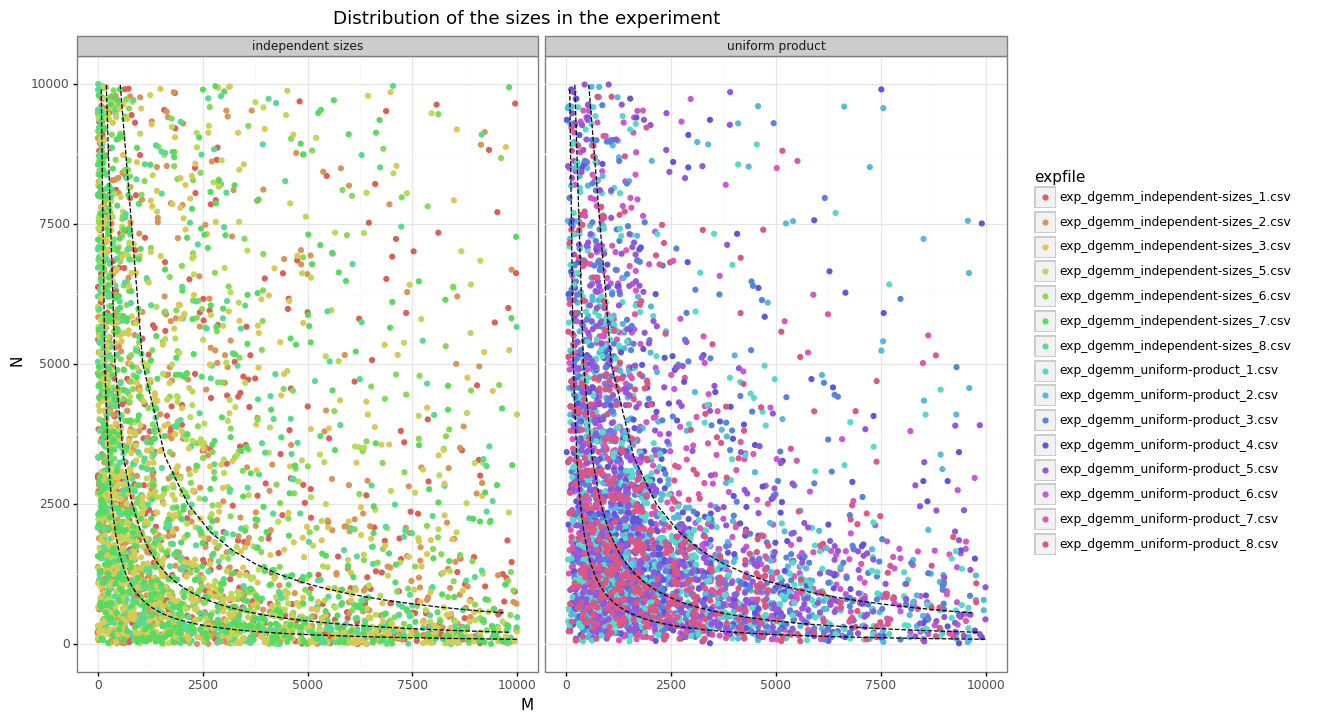

<ggplot: (-9223363290366737653)>


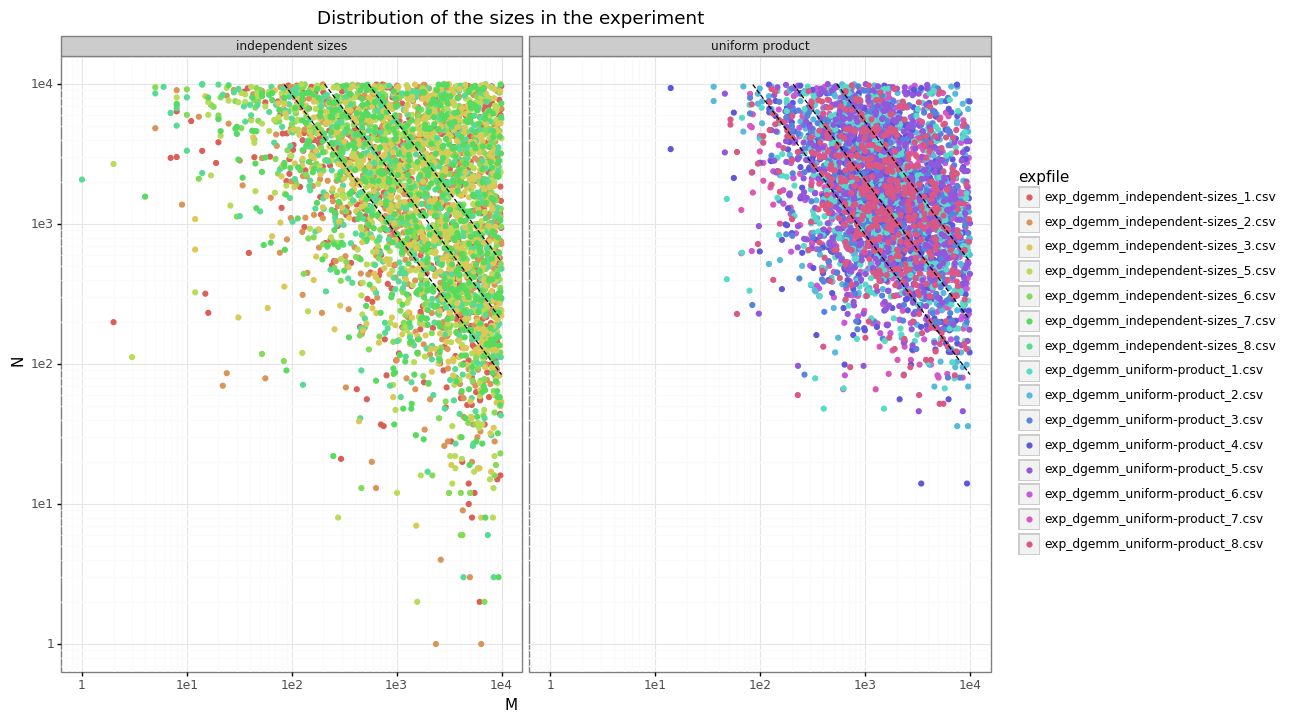

<ggplot: (8746488006769)>


In [5]:
plot = (ggplot(df[['expfile', 'exp_kind', 'm', 'n', 'k']].drop_duplicates())
    + aes(x='m', y='n', color='expfile')
    + geom_point()
    + geom_line(aes(group='group'), data=equi_line, color='black', linetype='dashed')
    + theme_bw()
    + labs(x='M', y='N')
    + ggtitle('Distribution of the sizes in the experiment')
    + expand_limits(y=0)
    + facet_wrap('exp_kind')
)
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

## Performance

In [6]:
aggregated_df = pandas.DataFrame(lr.regression(df, lr.compute_dgemm_reg)).set_index('jobid')
names = df[['jobid', 'expfile', 'exp_kind']].drop_duplicates().set_index('jobid')
aggregated_df['expfile'] = names['expfile']
aggregated_df['exp_kind'] = names['exp_kind']
aggregated_df = aggregated_df.reset_index()
aggregated_df.head()

,jobid,intercept,mnk,mn,mk,nk,tvalue_mnk,tvalue_mn,tvalue_mk,tvalue_nk,...,tvalue_nk_residual,avg_gflops,function,cluster,node,expfile_hash,cpu,start_time,expfile,exp_kind
0,1964858,0.002149,7.125026e-11,1.737503e-10,2.396622e-09,3.366042e-09,503.540939,4.107523,50.827855,76.217234,...,10.217860,24.978952,dgemm,dahu,5,aa23cca3ed8af2e2ae56ee83997bf4622d167476c7b010...,0,1606771939,exp_dgemm_independent-sizes_7.csv,independent sizes
1,1964858,0.002053,6.477148e-11,1.556197e-10,2.274699e-09,3.367924e-09,500.042261,4.018774,52.698798,83.304875,...,8.287674,27.265600,dgemm,dahu,5,aa23cca3ed8af2e2ae56ee83997bf4622d167476c7b010...,1,1606771939,exp_dgemm_independent-sizes_7.csv,independent sizes
2,1964858,0.002170,7.265031e-11,1.689064e-10,2.374359e-09,3.426582e-09,570.390026,4.435950,55.941599,86.194759,...,9.577380,24.539316,dgemm,dahu,6,aa23cca3ed8af2e2ae56ee83997bf4622d167476c7b010...,0,1606771939,exp_dgemm_independent-sizes_7.csv,independent sizes
3,1964858,0.001997,6.423608e-11,1.419387e-10,2.289494e-09,3.163478e-09,422.621996,3.123777,45.202927,66.684222,...,3.454645,27.570262,dgemm,dahu,6,aa23cca3ed8af2e2ae56ee83997bf4622d167476c7b010...,1,1606771939,exp_dgemm_independent-sizes_7.csv,independent sizes
4,1964858,0.002122,6.853264e-11,1.265098e-10,2.344958e-09,3.330015e-09,471.741525,2.912976,48.439057,73.440922,...,6.444255,25.924747,dgemm,dahu,7,aa23cca3ed8af2e2ae56ee83997bf4622d167476c7b010...,0,1606771939,exp_dgemm_independent-sizes_7.csv,independent sizes


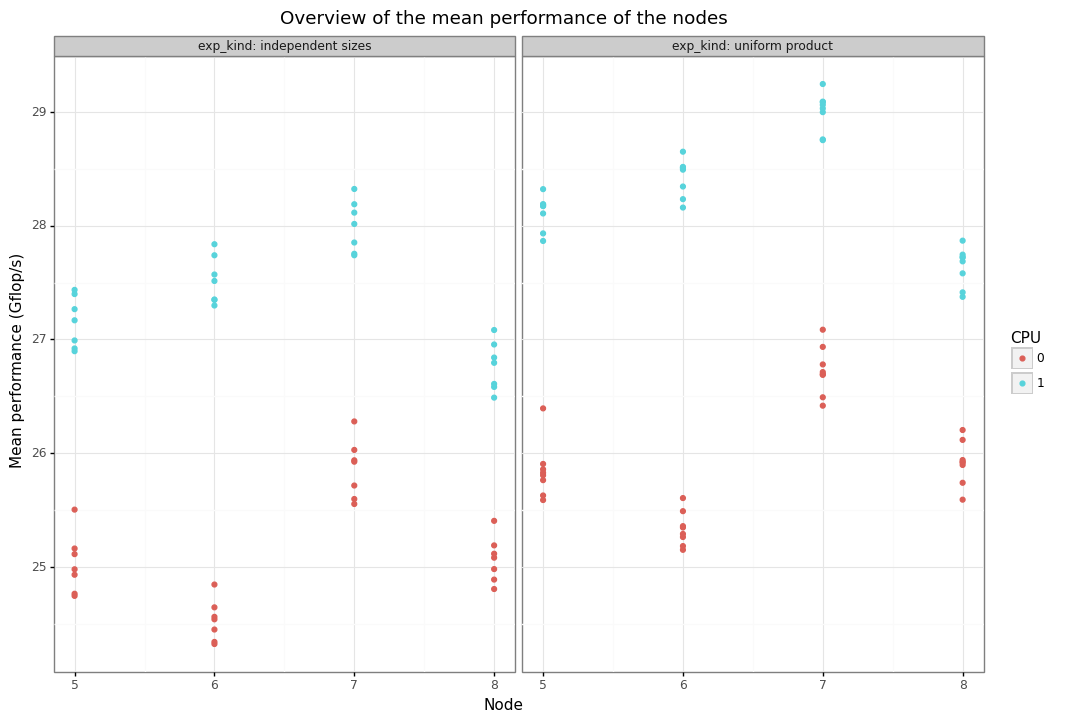

<ggplot: (8746487704054)>

In [7]:
(ggplot(aggregated_df)
    + aes(x='node', y='avg_gflops', color='factor(cpu)')
    + geom_point()
    + theme_bw()
    + facet_wrap('exp_kind', labeller='label_both')
    + labs(x='Node', y='Mean performance (Gflop/s)', color='CPU')
    + ggtitle('Overview of the mean performance of the nodes')
   # + expand_limits(y=0)
)

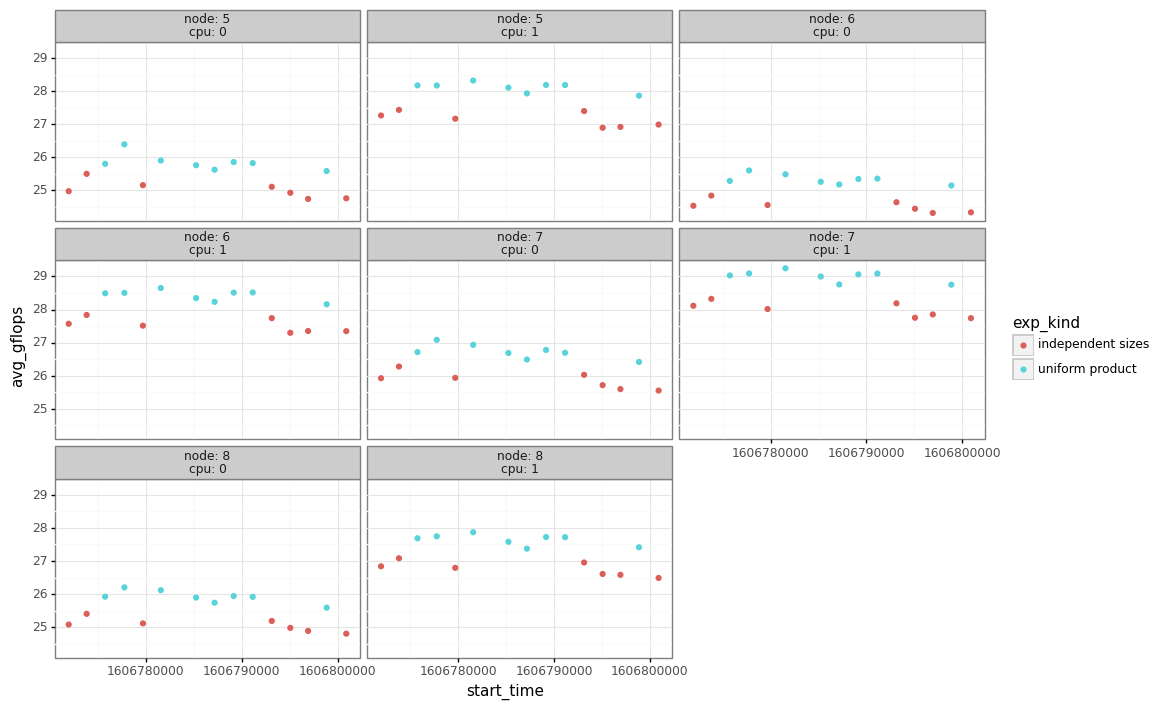

<ggplot: (8746489919706)>


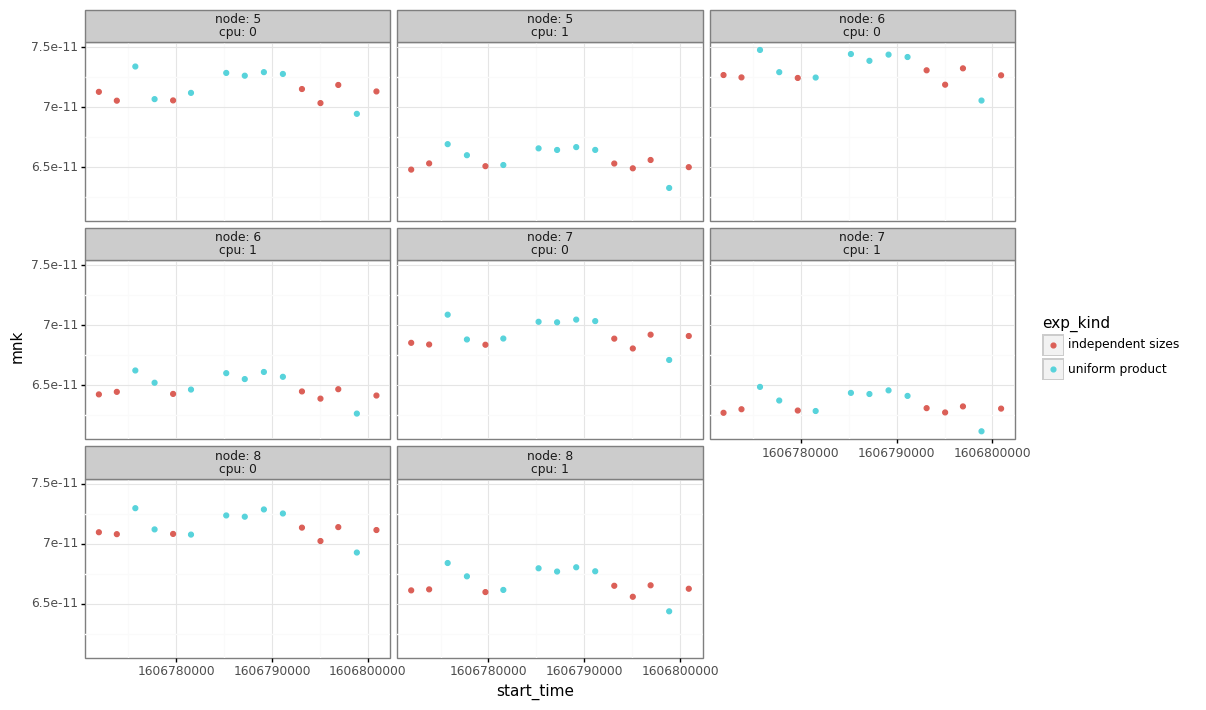

<ggplot: (8746482827314)>


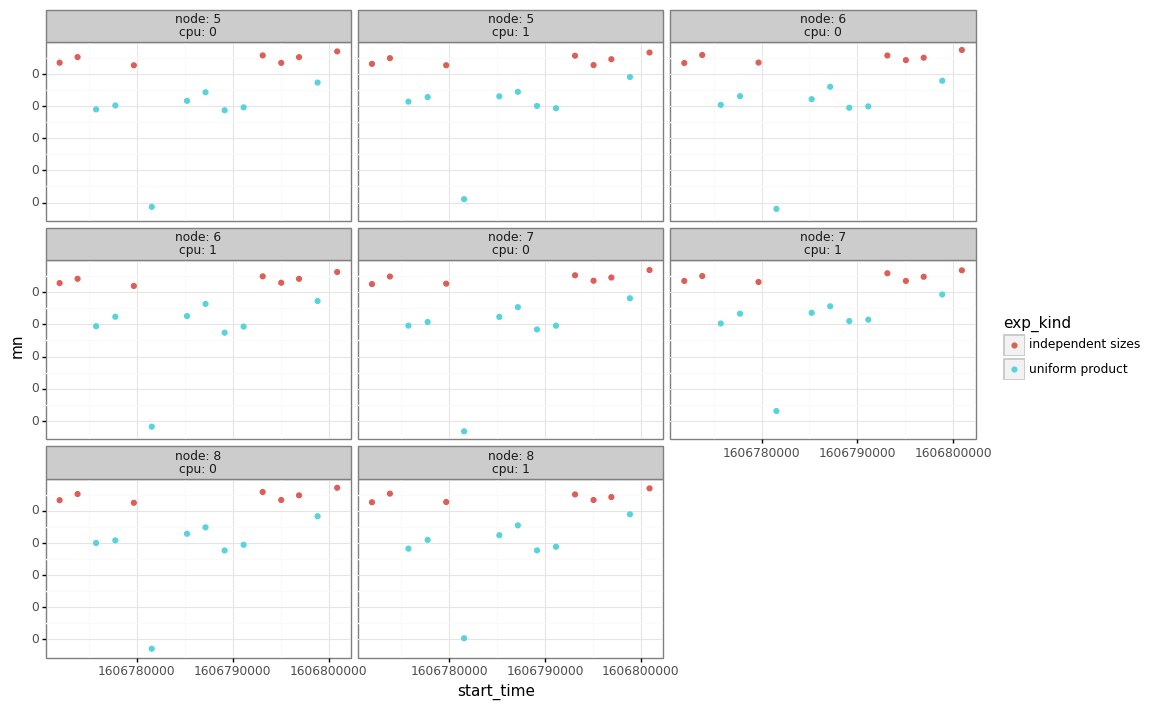

<ggplot: (-9223363290371825306)>


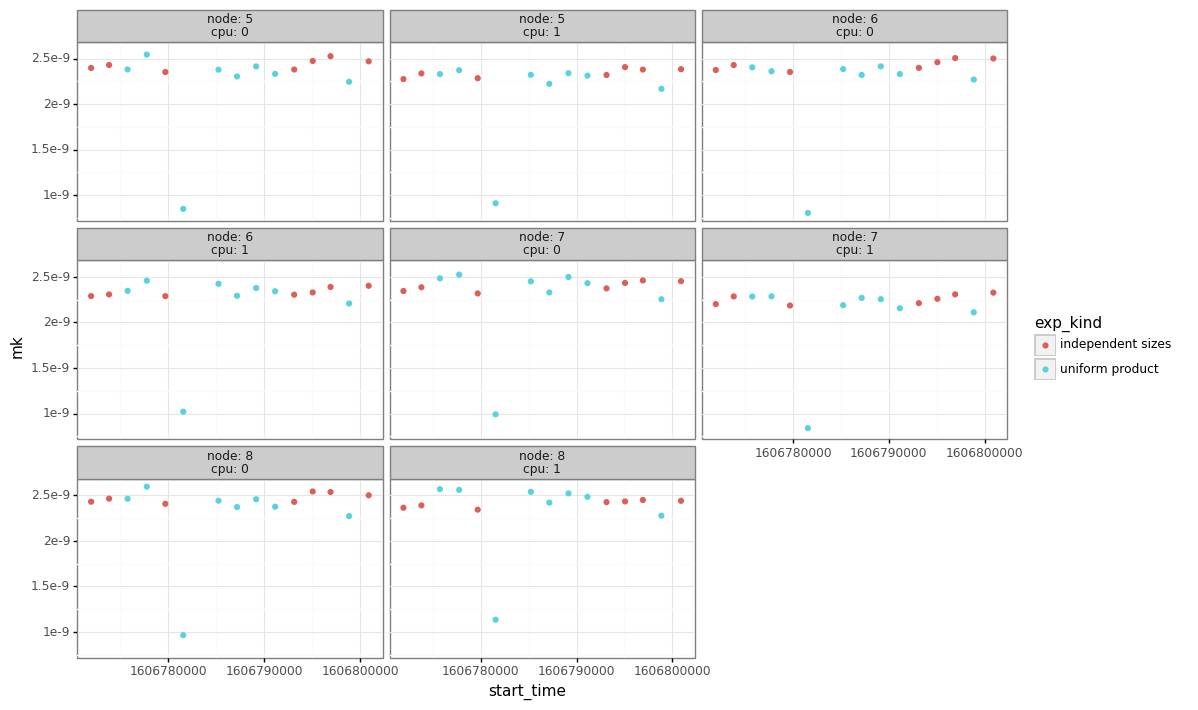

<ggplot: (8746440315638)>


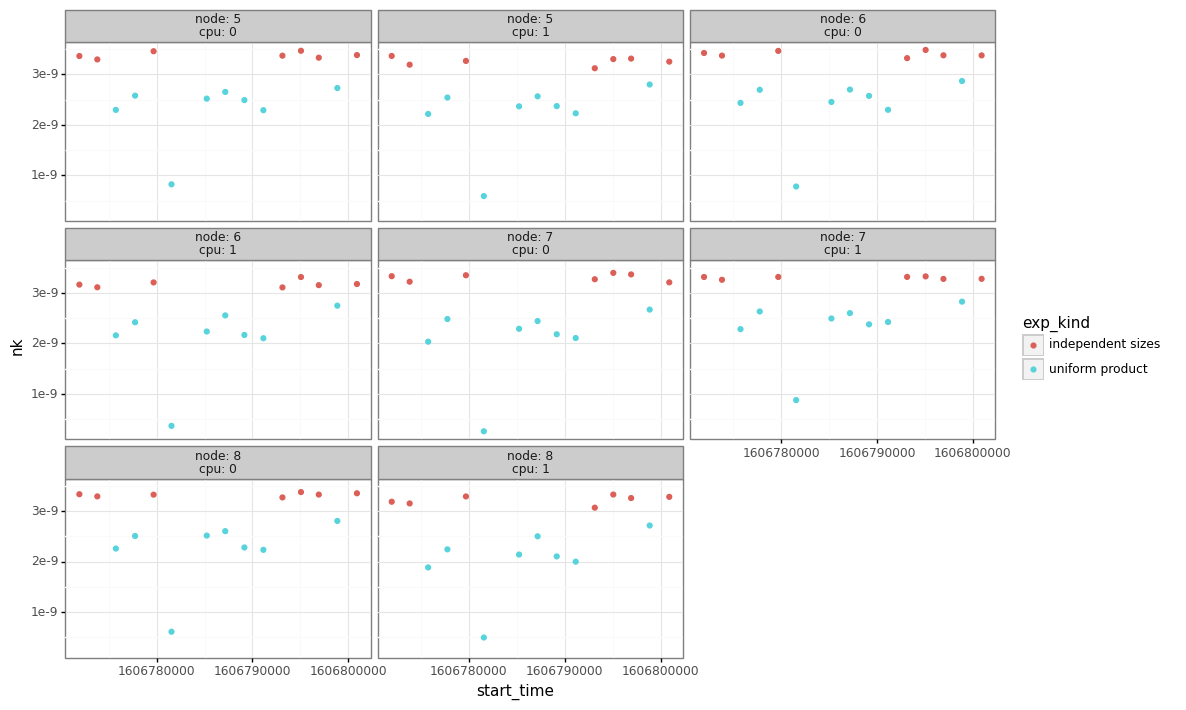

<ggplot: (8746487670038)>


In [8]:
for col in ['avg_gflops', 'mnk', 'mn', 'mk', 'nk']:
    print(ggplot(aggregated_df)
        + aes(x='start_time', y=col, color='exp_kind')
        + geom_point()
        + theme_bw()
        + facet_wrap(['node', 'cpu'], labeller='label_both')
    )

In [9]:
first_exp = set(df.groupby('exp_kind')[['jobid']].min()['jobid'])
df[(df['jobid'].isin(first_exp)) & (df['node'] == 5)][['jobid', 'expfile', 'm', 'n', 'k', 'node', 'cpu', 'duration']].to_csv('/tmp/dgemm_raw_data.csv', index=False)

In [10]:
df[['expfile', 'm', 'n', 'k']].drop_duplicates().to_csv('/tmp/dgemm_expfile_content.csv', index=False)

In [11]:
aggregated_df.to_csv('/tmp/dgemm_agr_data.csv', index=False)

In [12]:
del df
del aggregated_df

## Monitoring

In [13]:
dataframes = []
for f in archives:
    tmp = ae.read_monitoring(f)
    expfile = ae.read_yaml(f, 'info.yaml')['expfile'][0]
    tmp['expfile'] = expfile
    tmp['exp_kind'] = 'independent sizes' if 'independent-sizes' in expfile else 'uniform product'
    dataframes.append(tmp)
monitoring = pandas.concat(dataframes)
monitoring['date'] = pandas.to_datetime(monitoring['start_time'], unit='s').astype(str)
for date in monitoring['date'].unique():
    monitoring.loc[monitoring['date'] == date, 'real_start_time'] = monitoring[monitoring['date'] == date]['timestamp'].min()
monitoring['start_exp'] -= monitoring['real_start_time']
monitoring['stop_exp'] -= monitoring['real_start_time']
monitoring['timestamp'] -= monitoring['real_start_time']
monitoring['cpu_id'] = monitoring['node'].astype(str) + ':' + monitoring['cpu'].astype(str)
monitoring['in_exp'] = (monitoring['timestamp'] > monitoring['start_exp'] + 60) & (monitoring['timestamp'] < monitoring['stop_exp'] - 60)
monitoring['hostname'] = monitoring['cluster'] + '-' + monitoring['node'].astype(str)
print(len(monitoring))
monitoring.head()

967936


,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,core,kind,start_exp,stop_exp,expfile,exp_kind,date,real_start_time,cpu_id,in_exp,hostname
0,0.004013,dahu,5,1964873,1606800901,d21f08ab3235de32d4d670443aaa0a849ce9ad6c218faa...,2.654864,0,0,frequency,623.550681,1229.392317,exp_dgemm_independent-sizes_1.csv,independent sizes,2020-12-01 05:35:01,1.606805e+09,5:0,False,dahu-5
1,5.007964,dahu,5,1964873,1606800901,d21f08ab3235de32d4d670443aaa0a849ce9ad6c218faa...,2.780346,0,0,frequency,623.550681,1229.392317,exp_dgemm_independent-sizes_1.csv,independent sizes,2020-12-01 05:35:01,1.606805e+09,5:0,False,dahu-5
2,10.013034,dahu,5,1964873,1606800901,d21f08ab3235de32d4d670443aaa0a849ce9ad6c218faa...,1.807507,0,0,frequency,623.550681,1229.392317,exp_dgemm_independent-sizes_1.csv,independent sizes,2020-12-01 05:35:01,1.606805e+09,5:0,False,dahu-5
3,15.018141,dahu,5,1964873,1606800901,d21f08ab3235de32d4d670443aaa0a849ce9ad6c218faa...,1.407348,0,0,frequency,623.550681,1229.392317,exp_dgemm_independent-sizes_1.csv,independent sizes,2020-12-01 05:35:01,1.606805e+09,5:0,False,dahu-5
4,20.023115,dahu,5,1964873,1606800901,d21f08ab3235de32d4d670443aaa0a849ce9ad6c218faa...,1.596405,0,0,frequency,623.550681,1229.392317,exp_dgemm_independent-sizes_1.csv,independent sizes,2020-12-01 05:35:01,1.606805e+09,5:0,False,dahu-5


In [14]:
grouped_mon = monitoring[monitoring.in_exp].groupby(['node', 'cpu', 'cpu_id', 'kind', 'expfile', 'exp_kind', 'real_start_time'])[['value']].mean().reset_index()
grouped_mon

,node,cpu,cpu_id,kind,expfile,exp_kind,real_start_time,value
0,5,0,5:0,frequency,exp_dgemm_independent-sizes_1.csv,independent sizes,1.606805e+09,2.085387
1,5,0,5:0,frequency,exp_dgemm_independent-sizes_2.csv,independent sizes,1.606797e+09,2.083716
2,5,0,5:0,frequency,exp_dgemm_independent-sizes_3.csv,independent sizes,1.606778e+09,2.120347
3,5,0,5:0,frequency,exp_dgemm_independent-sizes_5.csv,independent sizes,1.606784e+09,2.106600
4,5,0,5:0,frequency,exp_dgemm_independent-sizes_6.csv,independent sizes,1.606801e+09,2.075992
...,...,...,...,...,...,...,...,...
235,8,1,8:1,temperature,exp_dgemm_uniform-product_4.csv,uniform product,1.606791e+09,60.118693
236,8,1,8:1,temperature,exp_dgemm_uniform-product_5.csv,uniform product,1.606780e+09,60.277523
237,8,1,8:1,temperature,exp_dgemm_uniform-product_6.csv,uniform product,1.606786e+09,59.837810
238,8,1,8:1,temperature,exp_dgemm_uniform-product_7.csv,uniform product,1.606789e+09,60.706830


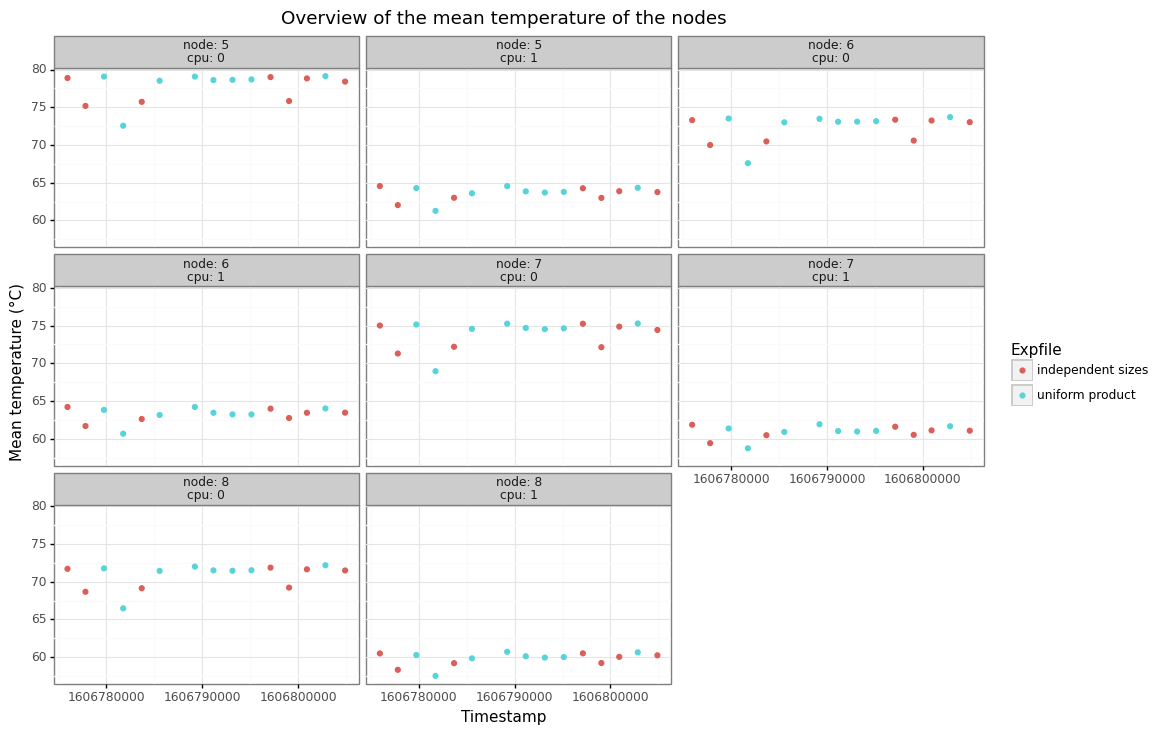

<ggplot: (-9223363290366958441)>

In [15]:
(ggplot(grouped_mon[grouped_mon['kind'] == 'temperature'])
    + aes(x='real_start_time', y='value', color='exp_kind')
    + geom_point()
    + theme_bw()
    + facet_wrap(['node', 'cpu'], labeller='label_both')
    + labs(x='Timestamp', y='Mean temperature (°C)', color='Expfile')
    + ggtitle('Overview of the mean temperature of the nodes')
)

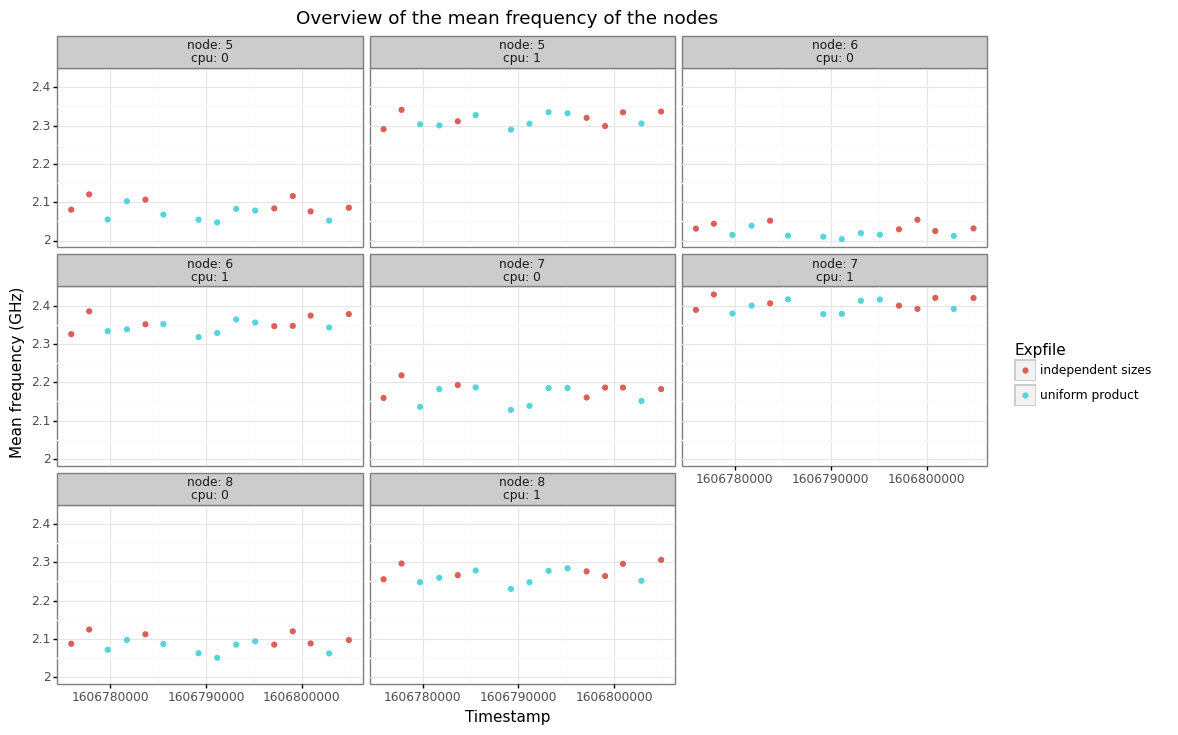

<ggplot: (8746487842645)>

In [16]:
(ggplot(grouped_mon[grouped_mon['kind'] == 'frequency'])
    + aes(x='real_start_time', y='value', color='exp_kind')
    + geom_point()
    + theme_bw()
    + facet_wrap(['node', 'cpu'], labeller='label_both')
    + labs(x='Timestamp', y='Mean frequency (GHz)', color='Expfile')
    + ggtitle('Overview of the mean frequency of the nodes')
)

In [17]:
import re
reg = re.compile('power_package-(?P<cpu_id>[0-9]+)(_(?P<sub_group>[a-z]+))?')
reg.fullmatch('power_package-1').groupdict()

{'cpu_id': '1', 'sub_group': None}

In [18]:
import numpy
import re

def melt_power(df, idcol):
    reg = re.compile('power_package-(?P<cpu_id>[0-9]+)(_(?P<sub_group>[a-z]+))?')
    result = []
    columns = list(df.columns)
    for col in columns:
        match = reg.fullmatch(col)
        if match is None:
            continue
        tmp = df[idcol].copy()
        tmp['value'] = df[col]
        tmp['CPU'] = int(match.groupdict()['cpu_id'])
        tmp['subgroup'] = str(match.groupdict()['sub_group'])
        result.append(tmp)
    return pandas.concat(result)

def read_monitoring_power(archive_name, columns=None):
    '''
    Read the durations of a BLAS calibration in an archive.
    '''
    csv_name = 'monitoring.csv'
    df = ae.read_archive_csv_enhanced(archive_name, csv_name, columns=columns)
    df['timestamp'] = pandas.to_datetime(df['timestamp'])
    columns = ['timestamp', 'cluster', 'node', 'jobid', 'start_time', 'expfile_hash']
    power = melt_power(df, columns)
    power['timestamp'] = power['timestamp'].astype(numpy.int64) / 10 ** 9
    power['timestamp'] = power['timestamp'] - power['timestamp'].min()
    return power

dataframes = []
for f in archives:
    tmp = read_monitoring_power(f)
    expfile = ae.read_yaml(f, 'info.yaml')['expfile'][0]
    tmp['expfile'] = expfile
    tmp['exp_kind'] = 'independent sizes' if 'independent-sizes' in expfile else 'uniform product'
    dataframes.append(tmp)
power = pandas.concat(dataframes)

for jobid in power['jobid'].unique():
    for col in ['start_exp', 'stop_exp']:
        val = monitoring[monitoring['jobid'] == jobid][col].unique()
        assert len(val) == 1
        power.loc[power['jobid'] == jobid, col] = val[0]
power.head()

,timestamp,cluster,node,jobid,start_time,expfile_hash,value,CPU,subgroup,expfile,exp_kind,start_exp,stop_exp
0,0.004013,dahu,5,1964873,1606800901,d21f08ab3235de32d4d670443aaa0a849ce9ad6c218faa...,40.023517,1,None,exp_dgemm_independent-sizes_1.csv,independent sizes,623.550681,1229.392317
1,5.007964,dahu,5,1964873,1606800901,d21f08ab3235de32d4d670443aaa0a849ce9ad6c218faa...,93.001800,1,None,exp_dgemm_independent-sizes_1.csv,independent sizes,623.550681,1229.392317
2,10.013034,dahu,5,1964873,1606800901,d21f08ab3235de32d4d670443aaa0a849ce9ad6c218faa...,104.631403,1,None,exp_dgemm_independent-sizes_1.csv,independent sizes,623.550681,1229.392317
3,15.018141,dahu,5,1964873,1606800901,d21f08ab3235de32d4d670443aaa0a849ce9ad6c218faa...,31.609852,1,None,exp_dgemm_independent-sizes_1.csv,independent sizes,623.550681,1229.392317
4,20.023115,dahu,5,1964873,1606800901,d21f08ab3235de32d4d670443aaa0a849ce9ad6c218faa...,40.533939,1,None,exp_dgemm_independent-sizes_1.csv,independent sizes,623.550681,1229.392317


In [19]:
grouped_power = power[(power['timestamp'] > power['start_exp']+60) & (power['timestamp'] < power['stop_exp']-60)].groupby(['subgroup', 'node', 'CPU', 'expfile', 'exp_kind', 'start_time'])[['value']].mean().reset_index()
grouped_power

,subgroup,node,CPU,expfile,exp_kind,start_time,value
0,None,5,0,exp_dgemm_independent-sizes_1.csv,independent sizes,1606800901,124.545306
1,None,5,0,exp_dgemm_independent-sizes_2.csv,independent sizes,1606793128,124.638598
2,None,5,0,exp_dgemm_independent-sizes_3.csv,independent sizes,1606773812,124.334880
3,None,5,0,exp_dgemm_independent-sizes_5.csv,independent sizes,1606779684,124.638808
4,None,5,0,exp_dgemm_independent-sizes_6.csv,independent sizes,1606796919,124.632435
...,...,...,...,...,...,...,...
235,dram,8,1,exp_dgemm_uniform-product_4.csv,uniform product,1606787162,11.167371
236,dram,8,1,exp_dgemm_uniform-product_5.csv,uniform product,1606775744,11.324317
237,dram,8,1,exp_dgemm_uniform-product_6.csv,uniform product,1606781552,11.031154
238,dram,8,1,exp_dgemm_uniform-product_7.csv,uniform product,1606785230,11.363337


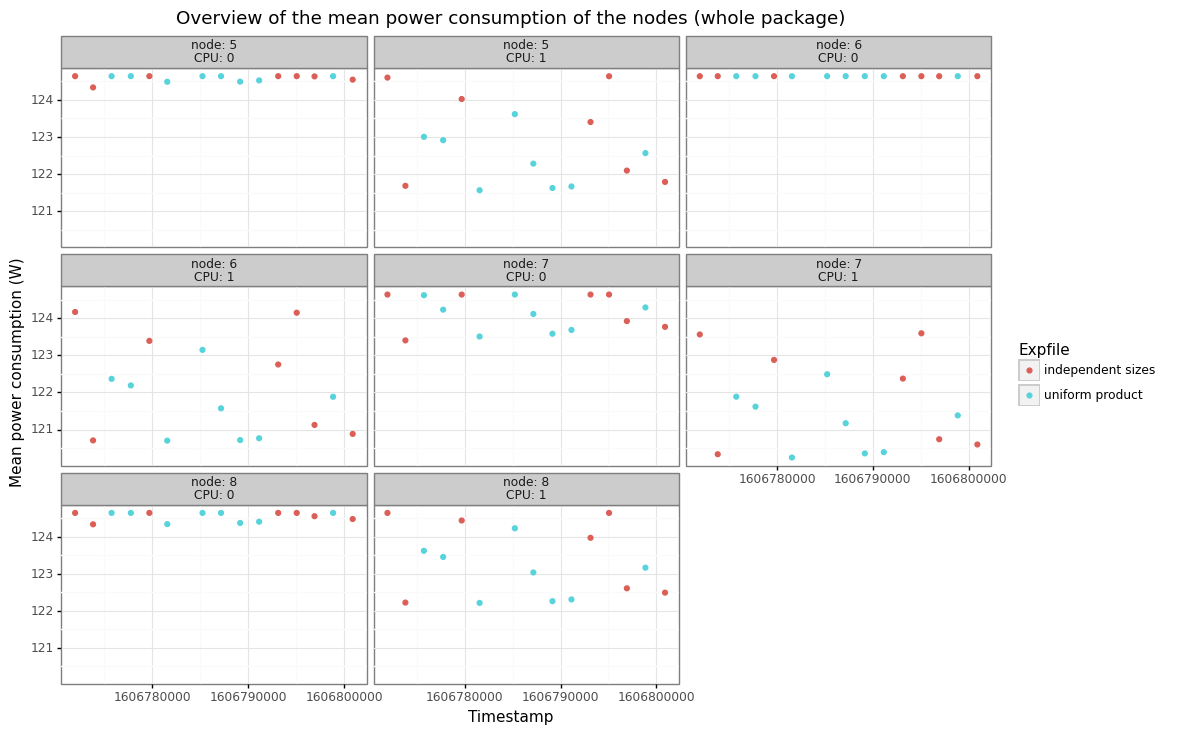

<ggplot: (-9223363290366731460)>

In [20]:
(ggplot(grouped_power[grouped_power['subgroup'] == 'None'])
    + aes(x='start_time', y='value', color='exp_kind')
    + geom_point()
    + theme_bw()
    + facet_wrap(['node', 'CPU'], labeller='label_both')
    + labs(x='Timestamp', y='Mean power consumption (W)', color='Expfile')
    + ggtitle('Overview of the mean power consumption of the nodes (whole package)')
)

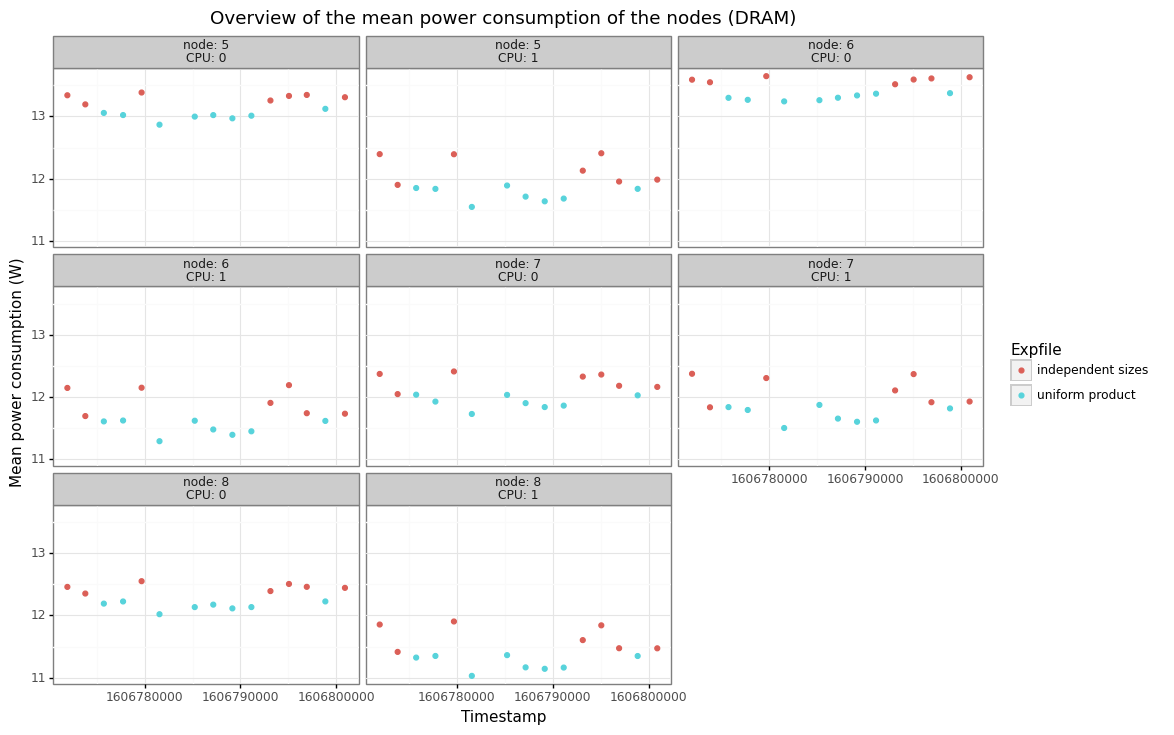

<ggplot: (8746436256583)>

In [21]:
(ggplot(grouped_power[grouped_power['subgroup'] == 'dram'])
    + aes(x='start_time', y='value', color='exp_kind')
    + geom_point()
    + theme_bw()
    + facet_wrap(['node', 'CPU'], labeller='label_both')
    + labs(x='Timestamp', y='Mean power consumption (W)', color='Expfile')
    + ggtitle('Overview of the mean power consumption of the nodes (DRAM)')
)

In [22]:
tmp_mon = grouped_mon.rename(columns={'real_start_time': 'start_time'})
tmp_pow = grouped_power.rename(columns={'CPU': 'cpu'})
tmp_pow['kind'] = 'power'
tmp_pow.loc[tmp_pow['subgroup'] == 'None', 'subgroup'] = 'package'
dump = pandas.concat([tmp_mon, tmp_pow])[['node', 'cpu', 'kind', 'expfile', 'exp_kind', 'start_time', 'value', 'subgroup']]
dump.to_csv('/tmp/dgemm_agr_monitoring.csv', index=False)
dump

,node,cpu,kind,expfile,exp_kind,start_time,value,subgroup
0,5,0,frequency,exp_dgemm_independent-sizes_1.csv,independent sizes,1.606805e+09,2.085387,NaN
1,5,0,frequency,exp_dgemm_independent-sizes_2.csv,independent sizes,1.606797e+09,2.083716,NaN
2,5,0,frequency,exp_dgemm_independent-sizes_3.csv,independent sizes,1.606778e+09,2.120347,NaN
3,5,0,frequency,exp_dgemm_independent-sizes_5.csv,independent sizes,1.606784e+09,2.106600,NaN
4,5,0,frequency,exp_dgemm_independent-sizes_6.csv,independent sizes,1.606801e+09,2.075992,NaN
...,...,...,...,...,...,...,...,...
235,8,1,power,exp_dgemm_uniform-product_4.csv,uniform product,1.606787e+09,11.167371,dram
236,8,1,power,exp_dgemm_uniform-product_5.csv,uniform product,1.606776e+09,11.324317,dram
237,8,1,power,exp_dgemm_uniform-product_6.csv,uniform product,1.606782e+09,11.031154,dram
238,8,1,power,exp_dgemm_uniform-product_7.csv,uniform product,1.606785e+09,11.363337,dram
